# NLP Assignment 1 - Set 13

## General Instructions


---



1. In case the link to dataset is not useful, same dataset can be downloaded from any online resource.

2. Each group is expected to submit jupyter notebook (.ipynb) with output for each cell.

3. No extension on the deadline

4. Submissions using other python IDEs will not be considered for grading.

Link to the Dataset: https://www.kaggle.com/bharadwaj6/kindle-reviews (Links to an external site.)

Description of Data: Dataset, consists of reviewText and Rating.



1.   Download the file and set it as a Dataframe. (1 Marks)
2.   Remove punctuations, special characters and stopwords from the text column. Convert the text to lower case. (3 Marks)
3.   Create two objects X and y. X will be the ' reviewText ' column dataframe and y will be the “Overall Rating” column. create a CountVectorizer object and split the data into training and testing sets. Train a MultinomialNB model and Display the confusion Matrix (5 Marks)
4.   Display the POS tagging on the first 4 rows of ‘reviewText’ (4 Marks)
5.   Build and display a dependency parser tree for the sentence:

“He staunchly opposes Jon's proposal to allow the wildlings to pass through the Wall before the White Walkers reach them and later participates in the mutiny against Jon, being the second to stab him.” (2 Marks)


## Import Libraries

In [173]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, roc_auc_score

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Dataset

### Connect to Gdrive

In [174]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/kaggle/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Fetch data

In [175]:
%cd /content/gdrive/My Drive/kaggle/kindle-reviews/
!ls

/content/gdrive/My Drive/kaggle/kindle-reviews
kindle_reviews.csv  kindle_reviews.json


In [176]:
# DATASET_ENCODING = "ISO-8859-1"
# DATASET_COLUMNS = ["asin", "helpful", "overall", "reviewText", "reviewTime", "reviewerID","reviewerName","summary", "unixReviewTime"]
# #DATASET_COLUMNS = ["target", "text"]
DATASET_PATH = "/content/gdrive/My Drive/kaggle/kindle-reviews/kindle_reviews.csv"

# df = pd.read_csv(DATASET_PATH, encoding = DATASET_ENCODING, names = DATASET_COLUMNS)
df = pd.read_csv(DATASET_PATH)
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,"05 5, 2014",A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,"01 6, 2014",AN0N05A9LIJEQ,critters,Different...,1388966400
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,"04 4, 2014",A795DMNCJILA6,dot,Oldie,1396569600
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,"02 19, 2014",A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...","03 19, 2014",A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200


In [177]:
df['overall'].value_counts()

5    575264
4    254013
3     96194
2     34130
1     23018
Name: overall, dtype: int64

In [178]:

# Check for null
df.isnull().sum()

Unnamed: 0           0
asin                 0
helpful              0
overall              0
reviewText          22
reviewTime           0
reviewerID           0
reviewerName      3816
summary              1
unixReviewTime       0
dtype: int64

In [179]:
# missing reviews and needs to be dropped
#drop the rows where there are no reviews
df.dropna(subset = ['reviewText'], inplace = True)

#changing the reviewTime column to be of datetime type
# df.reviewTime = pd.to_datetime(df.reviewTime)
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

#creating a column with just the year
df['Year'] = df.reviewTime.dt.year
df.head()

,Unnamed: 0,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,Year
0,0,B000F83SZQ,"[0, 0]",5,I enjoy vintage books and movies so I enjoyed ...,2014-05-05,A1F6404F1VG29J,Avidreader,Nice vintage story,1399248000,2014
1,1,B000F83SZQ,"[2, 2]",4,This book is a reissue of an old one; the auth...,2014-01-06,AN0N05A9LIJEQ,critters,Different...,1388966400,2014
2,2,B000F83SZQ,"[2, 2]",4,This was a fairly interesting read. It had ol...,2014-04-04,A795DMNCJILA6,dot,Oldie,1396569600,2014
3,3,B000F83SZQ,"[1, 1]",5,I'd never read any of the Amy Brewster mysteri...,2014-02-19,A1FV0SX13TWVXQ,"Elaine H. Turley ""Montana Songbird""",I really liked it.,1392768000,2014
4,4,B000F83SZQ,"[0, 1]",4,"If you like period pieces - clothing, lingo, y...",2014-03-19,A3SPTOKDG7WBLN,Father Dowling Fan,Period Mystery,1395187200,2014


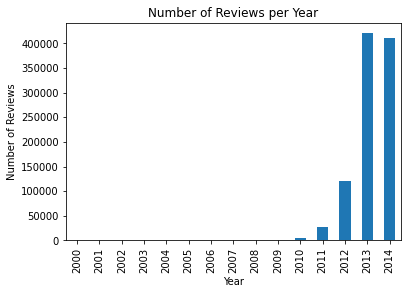

In [180]:
df.Year.value_counts().sort_index().plot(kind = 'bar')
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.show()

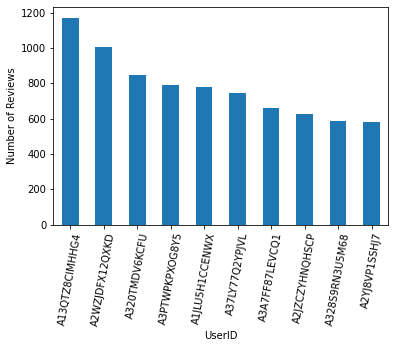

In [181]:
# Top 10 users based on reviews

df.reviewerID.value_counts().head(10).plot(kind = 'bar')
plt.xticks(rotation = 80)
plt.xlabel('UserID')
plt.ylabel('Number of Reviews')
plt.show()

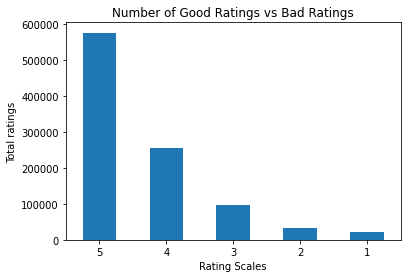

In [182]:
# Ratings count

df.overall.value_counts().plot(kind = 'bar')
plt.title('Number of Good Ratings vs Bad Ratings')
plt.xlabel('Rating Scales')
plt.xticks(rotation = 0)
plt.ylabel('Total ratings')
plt.show()

## Text Preprocessing

In [183]:
reviews = df[['reviewText', 'overall']]
originalReviewText = reviews['reviewText'].copy()
reviews.head()

,reviewText,overall
0,I enjoy vintage books and movies so I enjoyed ...,5
1,This book is a reissue of an old one; the auth...,4
2,This was a fairly interesting read. It had ol...,4
3,I'd never read any of the Amy Brewster mysteri...,5
4,"If you like period pieces - clothing, lingo, y...",4


In [184]:
# Remove punctuations, special characters and stopwords from the text column. Convert the text to lower case.

punc = str.maketrans('', '', string.punctuation)
#apply the empty mapping table to each element of the series where x is the review for one document.
reviews['reviewText'] = reviews['reviewText'].apply(lambda x : ' '.join(word.translate(punc) for word in x.split()))

#removing words that is non alpha
reviews['reviewText'] = reviews['reviewText'].apply(lambda x: ' '.join(word for word in x.split() if word.isalpha()))

#making all words to be lowercase
reviews['reviewText'] = reviews['reviewText'].apply(lambda x: ' '.join(word.lower() for word in x.split()))


reviews.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

,reviewText,overall
0,i enjoy vintage books and movies so i enjoyed ...,5
1,this book is a reissue of an old one the autho...,4
2,this was a fairly interesting read it had old ...,4
3,id never read any of the amy brewster mysterie...,5
4,if you like period pieces clothing lingo you w...,4


In [185]:

#list of stop words
stop = stopwords.words('english')

#removing the stop words
reviews['reviewText'] = reviews['reviewText'].apply(lambda x : ' '.join(word for word in x.split() if word not in stop))

# #Lemmatize words to reduce them to their root form. Note: added the pos = 'v' to reduce the incoming word to verb root
# lem = WordNetLemmatizer()
# reviews['reviewText'] = reviews['reviewText'].apply(lambda x : ' '.join(lem.lemmatize(word, pos = 'v') for word in x.split()))

reviews.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,reviewText,overall
0,enjoy vintage books movies enjoyed reading boo...,5
1,book reissue old one author born era say nero ...,4
2,fairly interesting read old style terminologyi...,4
3,id never read amy brewster mysteries one reall...,5
4,like period pieces clothing lingo enjoy myster...,4


## Split the data into training and testing sets

In [186]:
X = reviews['reviewText']

y = reviews['overall']

print(X)

0         enjoy vintage books movies enjoyed reading boo...
1         book reissue old one author born era say nero ...
2         fairly interesting read old style terminologyi...
3         id never read amy brewster mysteries one reall...
4         like period pieces clothing lingo enjoy myster...
                                ...                        
982614    yasss hunny great read dre mess cherika refuse...
982615    enjoyed book beginning end far lex hoe sneaky ...
982616    great book cherika fool let man get away much ...
982617    say excellent book please believe definitely p...
982618    book everything hope alexus wise move lawd tho...
Name: reviewText, Length: 982597, dtype: object


Coverting rating to positive and negative

less than 3 = negative
greater than 3 = positive

In [187]:
reviews['overall'] = np.where(reviews['overall'] > 2, 1, 0)
reviews.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,reviewText,overall
0,enjoy vintage books movies enjoyed reading boo...,1
1,book reissue old one author born era say nero ...,1
2,fairly interesting read old style terminologyi...,1
3,id never read amy brewster mysteries one reall...,1
4,like period pieces clothing lingo enjoy myster...,1


In [188]:
reviews.overall.value_counts()

1    925449
0     57148
Name: overall, dtype: int64

In [189]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size = .25, random_state = 42, stratify = y)



In [190]:
print(np.unique(Ytrain.values,return_counts=True))

(array([0, 1]), array([ 42861, 694086]))


In [191]:
# size of the datsets

print("\n Xtrain :\n")
print(Xtrain.head())
print(Xtrain.shape)

print("\n Xtest :\n")
print(Xtest.head())
print(Xtest.shape)

print("\n Ytrain :\n")
print(Ytrain.head())
print(Ytrain.shape)

print("\n Ytest :\n")
print(Ytest.head())
print(Ytest.shape)



 Xtrain :

254057    nice case sturdy magnet works well product des...
282137    found new favorite book long way joy read fell...
608486    dear lordwhat thatshort freaking funfingtastic...
913578    ok reason first review didnt take ugh anyways ...
316334    great start series ive read second book alread...
Name: reviewText, dtype: object
(736947,)

 Xtest :

238254    think youll enjoy one fun read surprise twists...
376587    enjoyed book looking something short fun one f...
154095    absolutely loved western ties sad wonderful se...
353536    ill admit dont lot experience mass transit tra...
314823    highly recommend book anyone interested becomi...
Name: reviewText, dtype: object
(245650,)

 Ytrain :

254057    1
282137    1
608486    1
913578    1
316334    1
Name: overall, dtype: int64
(736947,)

 Ytest :

238254    1
376587    1
154095    1
353536    1
314823    1
Name: overall, dtype: int64
(245650,)


In [192]:
cv=CountVectorizer(min_df=0,max_df=1,ngram_range=(1,1))
#transformed train reviews
cv_train_reviews=cv.fit_transform(Xtrain)
#transformed test reviews
cv_test_reviews=cv.transform(Xtest)

In [193]:

print("\n cv_train_reviews :\n")
# print(cv_train_reviews)
print(cv_train_reviews.shape)

print("\n cv_test_reviews :\n")
# print(cv_test_reviews)
print(cv_test_reviews.shape)


 cv_train_reviews :

(736947, 496577)

 cv_test_reviews :

(245650, 496577)


## Train a Multinomial Naive Bayes model

In [194]:
reviews.overall.value_counts()

1    925449
0     57148
Name: overall, dtype: int64

In [195]:

nb = MultinomialNB()
nb.fit(cv_train_reviews, Ytrain)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [196]:
mnb_pred = nb.predict(cv_test_reviews)
accuracy_score(Ytest,mnb_pred)

0.9417870954610218

In [197]:
cv_report = classification_report(Ytest,mnb_pred,target_names = ['0','1'])
print(cv_report)

              precision    recall  f1-score   support

           0       0.26      0.00      0.00     14287
           1       0.94      1.00      0.97    231363

    accuracy                           0.94    245650
   macro avg       0.60      0.50      0.49    245650
weighted avg       0.90      0.94      0.91    245650



In [198]:
cm_cv = confusion_matrix(Ytest,mnb_pred)
cm_cv

array([[     7,  14280],
       [    20, 231343]])

In [199]:
cm_cv = pd.DataFrame(cm_cv, index=[0,4], columns=[0,4])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

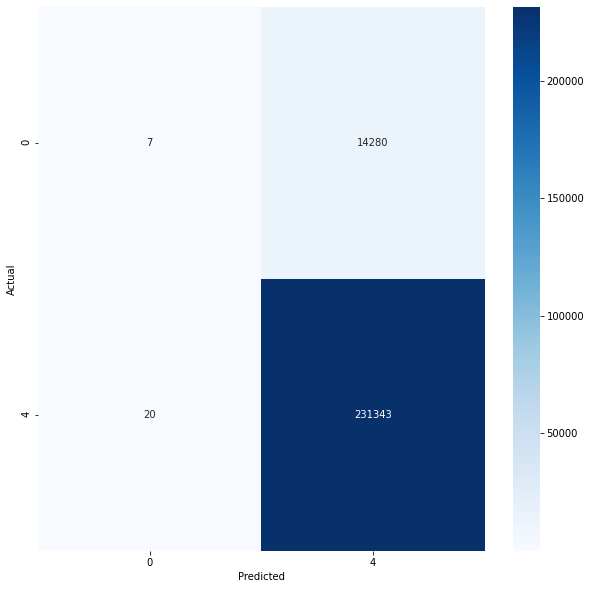

In [200]:
plt.figure(figsize = (10,10))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

In [201]:
print('Training Accuracy: {:.2f}'.format(nb.score(cv_train_reviews, Ytrain)))
print('Testing Accuracy: {:.2f}'.format(nb.score(cv_test_reviews, Ytest)))

Training Accuracy: 0.95
Testing Accuracy: 0.94


## POS tagging

Steps Involved:

1. Tokenize text (word_tokenize)
2. apply pos_tag to above step that is nltk.pos_tag(tokenize_text)

Ref : https://medium.com/@gianpaul.r/tokenization-and-parts-of-speech-pos-tagging-in-pythons-nltk-library-2d30f70af13b

In [202]:
def POSTagMethod(ptData):
  for i in ptData:
    print(i)
    tokens = nltk.word_tokenize(i)
    print("\t Tokens : ", tokens)
    postext = nltk.pos_tag(tokens)
    print("\t Parts Of Speech : ", postext)
    print('\n')
  


In [203]:
# Post Tagging method called for pre processed data
ptData1 = X.head(4)
print(ptData1)

0    enjoy vintage books movies enjoyed reading boo...
1    book reissue old one author born era say nero ...
2    fairly interesting read old style terminologyi...
3    id never read amy brewster mysteries one reall...
Name: reviewText, dtype: object


In [204]:
POSTagMethod(ptData1)

enjoy vintage books movies enjoyed reading book plot unusual dont think killing someone selfdefense leaving scene body without notifying police hitting someone jaw knock would wash todaystill good read
	 Tokens :  ['enjoy', 'vintage', 'books', 'movies', 'enjoyed', 'reading', 'book', 'plot', 'unusual', 'dont', 'think', 'killing', 'someone', 'selfdefense', 'leaving', 'scene', 'body', 'without', 'notifying', 'police', 'hitting', 'someone', 'jaw', 'knock', 'would', 'wash', 'todaystill', 'good', 'read']
	 Parts Of Speech :  [('enjoy', 'NN'), ('vintage', 'NN'), ('books', 'NNS'), ('movies', 'NNS'), ('enjoyed', 'VBD'), ('reading', 'VBG'), ('book', 'NN'), ('plot', 'NN'), ('unusual', 'JJ'), ('dont', 'NN'), ('think', 'VBP'), ('killing', 'VBG'), ('someone', 'NN'), ('selfdefense', 'NN'), ('leaving', 'VBG'), ('scene', 'NN'), ('body', 'NN'), ('without', 'IN'), ('notifying', 'VBG'), ('police', 'NN'), ('hitting', 'VBG'), ('someone', 'NN'), ('jaw', 'NN'), ('knock', 'NN'), ('would', 'MD'), ('wash', 'VB')

In [205]:
# Post Tagging method called for Original data
ptData2 = originalReviewText.head(4)
print(ptData2)

0    I enjoy vintage books and movies so I enjoyed ...
1    This book is a reissue of an old one; the auth...
2    This was a fairly interesting read.  It had ol...
3    I'd never read any of the Amy Brewster mysteri...
Name: reviewText, dtype: object


In [206]:
POSTagMethod(ptData2)

I enjoy vintage books and movies so I enjoyed reading this book.  The plot was unusual.  Don't think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.
	 Tokens :  ['I', 'enjoy', 'vintage', 'books', 'and', 'movies', 'so', 'I', 'enjoyed', 'reading', 'this', 'book', '.', 'The', 'plot', 'was', 'unusual', '.', 'Do', "n't", 'think', 'killing', 'someone', 'in', 'self-defense', 'but', 'leaving', 'the', 'scene', 'and', 'the', 'body', 'without', 'notifying', 'the', 'police', 'or', 'hitting', 'someone', 'in', 'the', 'jaw', 'to', 'knock', 'them', 'out', 'would', 'wash', 'today.Still', 'it', 'was', 'a', 'good', 'read', 'for', 'me', '.']
	 Parts Of Speech :  [('I', 'PRP'), ('enjoy', 'VBP'), ('vintage', 'JJ'), ('books', 'NNS'), ('and', 'CC'), ('movies', 'NNS'), ('so', 'RB'), ('I', 'PRP'), ('enjoyed', 'VBP'), ('reading', 'VBG'), ('this', 'DT'), ('book', 'NN'),

## Dependency Parser Tree

Build and display a dependency parser tree for the sentence:

“He staunchly opposes Jon's proposal to allow the wildlings to pass through the Wall before the White Walkers reach them and later participates in the mutiny against Jon, being the second to stab him.”

In [207]:
sentence = "He staunchly opposes Jon's proposal to allow the wildlings to pass through the Wall before the White Walkers reach them and later participates in the mutiny against Jon, being the second to stab him."

doc = nlp(sentence)
options = {"compact": True, "bg": "#09a3d5",
           "color": "white", "font": "Source Sans Pro"}
displacy.render(doc,style="dep",options=options,jupyter=True)


### Entity visualizer

In [208]:
colors1 = {"ORG": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options1 = {"colors": colors1}
displacy.render(doc, style="ent",options=options1,jupyter=True)